---

# Implementation of the Perceptron Learning Algorithm on Iris Data Set
By: Laura Moses

---

## Definition
The **Perceptron Learning Algorithm** (PLA) is a simple neural network which approximates a single neuron with $n$ binary inputs. 
The perceptron is an algorithm for supervised learning of binary classifiers. A binary classifier is a function which can decide whether or not an input, represented by a vector of numbers, can be 100% accurate if data are linearly separable

---

### Uses
The PLA algorithm is commonly used for:
* Classification

---

### Advantages
* The algorithm is simple

---

### Disadvantages
* Models can overfit data without regularization 

---

## The Perceptron Algorithm
Suppose $X \subseteq \mathbb{R}^2$ and $Y=\{1,-1\}$.
1. Initialize $\bar w \in \mathbb{R}^3$ randomly
1. For each $(x,y) \in D$
    1. Form $\bar x = [1.0, x_1, x_2]^T$
    1. If $sign(\bar w^T \bar x) \neq y$, update $\bar w$ with $\bar w \to \bar w + y \bar x$    
If $epoch=k$, repeat Step 2 $k$ times.
1. Output is $g(x)=sign(\bar w^T \bar x)$ where $g(x)$ is the final hypothesis $\approx f$ the target function

---

## The Model
Let $$D={(x^i, y^i), \cdots,(x^N, y^N)},$$ where $$y^i = species \space setosa \space or \space versicolor,$$ $$x^i = sepal \space length \space and \space sepal \space width.$$

There are 50 data points for each iris species, so $D$ has a total of $N = 100$ data points. 

The data set will be split into a training data set and a test data set  such that

$$D_{training} \subseteq D$$ and $$D_{test} \subseteq D$$ and $$D_{training} \cap D_{test} = D$$

To split the total data set, we choose 35 random data points from each species, using the remaining 15 for each species in the test data set. Thus, the training dataset will consist of 70 data points total and the test dataset will have 30 data points total.

---

### Iris Dataset
This example uses the `iris` dataset from `RDatasets`. The data is loaded as a `DataFrame` with columns:
* `SepalLength`
* `SepalWidth`
* `PetalLength`
* `PetalWidth`
* `Species`

The intention is to classify data from the `iris` data, using PLA to predict the species of flower based off of measurements of sepal length and width.

---

To access this data set and run this notebook, we will need the following packages:
* Rdatasets [documentation](https://github.com/JuliaStats/RDatasets.jl)
* Plots [documentation](http://docs.juliaplots.org/latest/)
* Random [documentationra](https://docs.julialang.org/en/v1/stdlib/Random/)

---

In [1]:
# import/load necessary packages
using RDatasets
using Plots
theme(:ggplot2)
using Random

---

### Split Data Into Training/Test Sets
The data $D$ will first be split into training and test sets based on a percentage of the dataset $p$ such that training data is $p\%$ of $D$ and test data is $(100-p)\%$ of $D$. 

The data will then be subdivided into points $X$ with labels $Y$ for each training and test set, i.e. $(X_{train}, Y_{train})$ and $(X_{test}, Y_{test})$.

---

In [49]:
""" Split shuffled data in a df into training and test fractions of train_prop and 1-train_prop
"""
function split_data(df, train_prop = 0.7)
    n = nrow(df)
    index = Random.shuffle(1:n)
    train_index = view(index, 1:floor(Int, train_prop*n))
    test_index = view(index, (floor(Int, train_prop*n)+1):n)
    
    return df[train_index,:], df[test_index,:]
end

# access the iris dataframe in RDatasets 
df = dataset("datasets", "iris")

# bi-species subset of iris: setosa, versicolor only
iris = df[1:100,:]

# Test function
train, test = split_data(iris, 0.7)

(70×5 DataFrame
 Row │ SepalLength  SepalWidth  PetalLength  PetalWidth  Species    
     │ Float64      Float64     Float64      Float64     Cat…       
─────┼──────────────────────────────────────────────────────────────
   1 │         6.3         2.5          4.9         1.5  versicolor
   2 │         5.1         3.8          1.5         0.3  setosa
   3 │         6.2         2.2          4.5         1.5  versicolor
   4 │         4.4         3.2          1.3         0.2  setosa
   5 │         6.4         2.9          4.3         1.3  versicolor
   6 │         6.1         2.8          4.7         1.2  versicolor
   7 │         4.6         3.1          1.5         0.2  setosa
   8 │         5.7         3.8          1.7         0.3  setosa
   9 │         5.7         4.4          1.5         0.4  setosa
  10 │         5.1         3.7          1.5         0.4  setosa
  11 │         5.7         2.6          3.5         1.0  versicolor
  ⋮  │      ⋮           ⋮            ⋮           ⋮   

In [3]:
"""
sort_x_y sorts a feature array X and label array Y in ascending order by labels Y. 
It then determines the index where the classification split takes place. 
This function can only be used with two label classifications. 
"""
function sort_x_y(X, Y)
    # store features and labels in temporary array
    temp_array = [(X[i], Y[i]) for i = 1:length(X)]
    
    # Sort by labels in ascending order
    sort!(temp_array, by = x -> x[2])
    
    # split into sorted x and sorted y arrays
    sorted_x = [temp_array[i][1] for i = 1:length(X)]
    sorted_y = [temp_array[i][2] for i = 1:length(X)]
    
    # Get last index for first classification label
    split_i = searchsortedlast(sorted_y, 0)
    
    return sorted_x, sorted_y, split_i
end;

In [50]:
"""
Split training and test data from a df into proportions train_pop and 1-train_prop, 
then subdivide training and test into features (x) and labels (y) using 
feat1, feat2 and class as column names in df, and label as one of the 
two distinguishing classifications. 
Returns x_train, y_train, x_test, y_test datasets and train_split_i and test_split_i indices. 
"""
function train_test_split(df, train_prop, feat1, feat2, class, label)
    # Split the data into training and test sets
    train, test = split_data(df, train_prop)
    
    # Separate train/test into features (x) and labels (y) sets
    x_train = [x for x in zip(train[1:nrow(train), feat1], train[1:nrow(train), feat2])]
    y_train = [train[i, class] == label ? 1 : -1 for i = 1:nrow(train)]
    x_test = [x for x in zip(test[1:nrow(test), feat1], test[1:nrow(test), feat2])]
    y_test = [test[i, class] == label ? 1 : -1 for i = 1:nrow(test)]
    
    # Sort sets and store split index
    x_train, y_train, train_split_i = sort_x_y(x_train, y_train)
    x_test, y_test, test_split_i = sort_x_y(x_test, y_test)
    
    # Return data sets and split indices
    return x_train, y_train, x_test, y_test, train_split_i, test_split_i
end

x_train, y_train, x_test, y_test, train_i, test_i = train_test_split(iris, 0.7, "SepalLength", "SepalWidth", "Species", "setosa");

---

The datasets are sorted within the function first by classification, with versicolor (-1) first, and setosa (1) following. This means that the first portion of the training and test are versicolor species and the last portion are setosa species. 

---

---

### Checking Assumptions

For the Perceptron Learning Algorithm to work, our data must be linearly separable. To visualize this, we will plot both training and test sets below. 

---

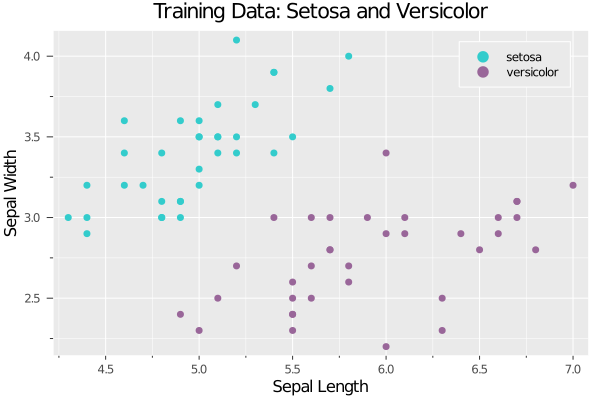

In [51]:
# Plot training set
scatter(xaxis = "Sepal Length",
        yaxis = "Sepal Width", 
        title = "Training Data: Setosa and Versicolor")

scatter!(x_train[(1+train_i):length(x_train)], 
         label = "setosa", 
         color = "#33CCCC")

scatter!(x_train[1:train_i], 
         label = "versicolor", 
         color = "#996699")

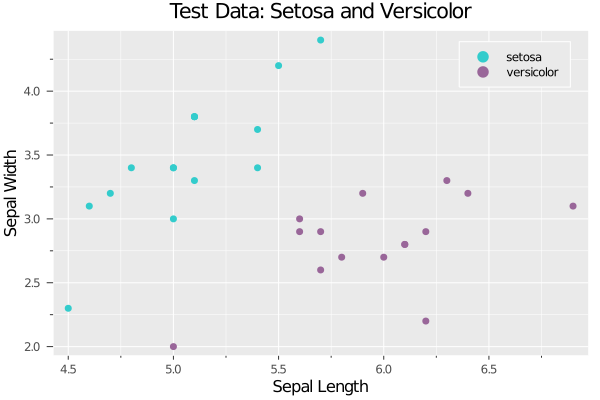

In [52]:
# Plot test set
scatter(xaxis = "Sepal Length",
        yaxis = "Sepal Width", 
        title = "Test Data: Setosa and Versicolor")

scatter!(x_test[(1+test_i):length(x_test)], 
         label = "setosa", 
         color = "#33CCCC")

scatter!(x_test[1:test_i], 
         label = "versicolor", 
         color = "#996699")

---

In the plot generated above, we can see that the data are, indeed, linearly separable. This is significant since a single perceptron will learn a linear seperator that partitions the data set into two distinct groups. That is, the target is a line $$y = mx+b$$ such that all data points above $y$ belong to one class of data, and all data points below $y$ belong to the other class of data. 

---

---

### Perceptron Functions

Below are the perceptron functions for activation, update rule, error count and learning algorithm. 

---

In [7]:
# Perceptron Activation Function
function sign(weights, x)
    x̄ = [1.0, x[1], x[2]]
    return weights'x̄ > 0 ? 1 : -1
end;

In [8]:
# Perceptron Update Rule
function perceptron_update_rule(weights, x, y)
    if sign(weights, x) != y
        weights += y*[1.0, x[1], x[2]]
    end
    return weights
end;

In [9]:
# Error Count
function error(weights, X, Y)
    return sum([Int(sign(weights, X[i]) != Y[i]) for i = 1:length(X)])
end;

In [10]:
# Iterate the perceptron update rule by randomly testing entries in the data set. 
function PLA(X, Y; epochs = 100000)
    # Assign random weights
    w = randn(3)

    # Save the error measures
    error_points = [(0.0, error(w, X, Y))]
    
    # A simple counter
    i = 1
    
    while error(w, X, Y) > 0 && i < epochs
        # Choose random entries to update (if possible)
        for j = 1:length(X)
            w = perceptron_update_rule(w, X[j], Y[j])
        end
        push!(error_points, (i, error(w, X, Y)))
        i += 1
    end
    return w, error_points
end;

---

For our 2-dimensional data set, the perceptron will learn weights that define the following 3-dimensional hyperplane: 
$$x_3 = w_1x_1 + w_2x_2 + w_3$$
$$x_2 = w_1x_1 + w_2$$
$$ 0 = w_1x_1 + w_2$$
$$ \rightarrow x_1 = -w_2/w_1$$
Setting $x_3 = 0$ and solving for $x_2$, we get the following line in 2-dimensional space: $$x_2 = -\frac{w_2}{w_3}x_1 - \frac{w_1}{w_3} = \frac{-w_2x_1 -w_1}{w_3}$$
Plotting this line on the iris scatter plot will show that the data has been split into two distinct groups: 

---

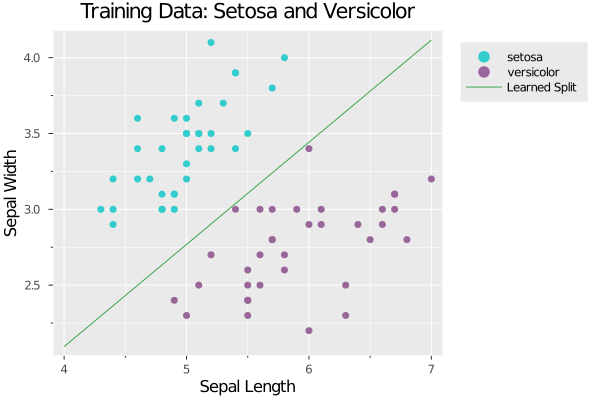

In [53]:
# Build model using training data
w, error_points = PLA(x_train, y_train);

# Plot the learned function 
# Plot training set
scatter(xaxis = "Sepal Length",
        yaxis = "Sepal Width", 
        title = "Training Data: Setosa and Versicolor",
        legend=:outertopright)

scatter!(x_train[(1+train_i):length(x_train)], 
         label = "setosa", 
         color = "#33CCCC")

scatter!(x_train[1:train_i], 
         label = "versicolor", 
         color = "#996699")

plot!([(x,(-w[2]*x - w[1]) / w[3]) for x = 4:7],
        label = "Learned Split")

---

To visualize how the number of misclassifications decrease with each epoch of the perceptron algorithm, use the error points defined above to plot. 

---

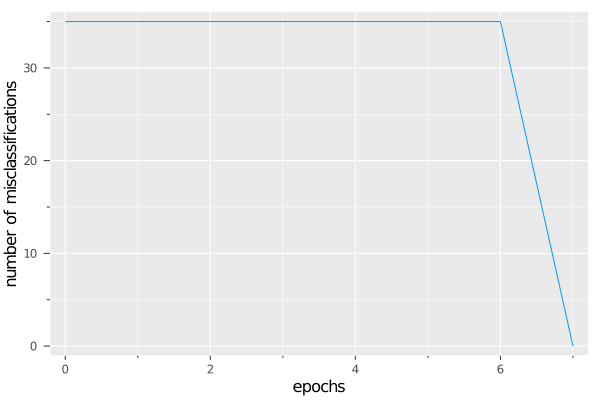

In [54]:
plot(error_points, 
    xaxis = "epochs", 
    yaxis = "number of misclassifications",
    legend = false)

---

We can see that in 7 epochs, we went from 35 misclassifications to zero on our training data set. 

---

Now that we've used our training data build our model weights, we want to measure the error rate of this algorithm. To do so I will be using the Classification Error method in which

$$Error = \frac{Number \space of \space incorrect \space predictions}{Total \space number \space of predictions \space made},$$

$$i.e. \space Error = \frac{1}{|D_{test}|} \sum_{i=1}^{|D_{test}|}[g(x^i)\neq y^i]$$

where $g(x_i)$ is the PLA function predicted label (setosa or versicolor) for a given feature $x^i$ in the `x_test` data set, and $y^i$ is the true corresponding label in the `y_test` data set. 

In [14]:
# Predictor function uses weights and features 
## to return the predicted iris label
function predictor(weights, x)
    return sign(weights, x) == 1 ? "setosa" : "versicolor"
end;

# True label function returns the corresponding label given an index
function true_label(y, index)
    return y[index] == 1 ? "setosa" : "versicolor"
end;

In [55]:
# Test our functions to preview results 
for i in 1:10
    k = rand(1:30)
    println("Testing training x^", k)
    println("The true label y^",k," = ", true_label(y_test, k))
    println("The predicted label g(x^",k,") = ", predictor(w, x_test[k]))
    println()
end

Testing training x^9
The true label y^9 = versicolor
The predicted label g(x^9) = versicolor

Testing training x^22
The true label y^22 = setosa
The predicted label g(x^22) = setosa

Testing training x^23
The true label y^23 = setosa
The predicted label g(x^23) = setosa

Testing training x^3
The true label y^3 = versicolor
The predicted label g(x^3) = versicolor

Testing training x^20
The true label y^20 = setosa
The predicted label g(x^20) = setosa

Testing training x^12
The true label y^12 = versicolor
The predicted label g(x^12) = versicolor

Testing training x^18
The true label y^18 = setosa
The predicted label g(x^18) = setosa

Testing training x^3
The true label y^3 = versicolor
The predicted label g(x^3) = versicolor

Testing training x^18
The true label y^18 = setosa
The predicted label g(x^18) = setosa

Testing training x^20
The true label y^20 = setosa
The predicted label g(x^20) = setosa



---

For all 10 randomly chosen observations from the test dataset, the prediction was correct. 

---

In [16]:
# define error_rate function 
function error_rate(X, Y, w)
    incorrect = 0
    for i = 1:length(X)
        if predictor(w, X[i]) != true_label(Y, i)
            incorrect += 1
        end
    end
    e = incorrect / length(X)
    return round(e, digits = 4)
end

error_rate (generic function with 1 method)

In [56]:
println("The test error rate is: ", error_rate(x_test, y_test, w))

The test error rate is: 0.03333333333333333


---

From our error rate, we can see that at least one observation was misclassified by our learned split. To visualize, the test data and learned split are plotted below. 

---

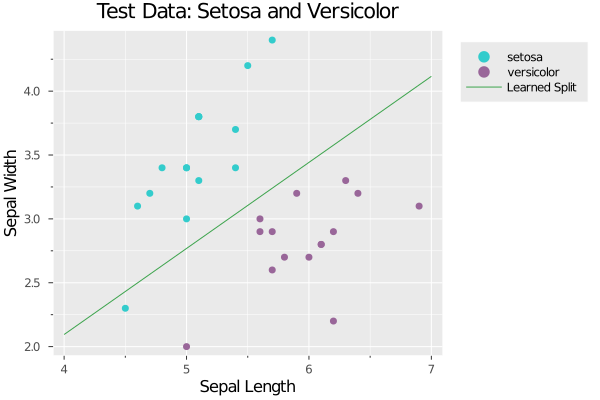

In [57]:
# Plot test set with the trained weights
scatter(xaxis = "Sepal Length",
        yaxis = "Sepal Width", 
        title = "Test Data: Setosa and Versicolor", 
        legend=:outertopright)

scatter!(x_test[(1+test_i):length(x_test)], 
         label = "setosa", 
         color = "#33CCCC")

scatter!(x_test[1:test_i], 
         label = "versicolor", 
         color = "#996699")

plot!([(x,(-w[2]*x - w[1]) / w[3]) for x = 4:7],
        label = "Learned Split")

# Conclusion
In this notebook we introduced the components of learning as well as the perceptron learning algorithm. We also used the perceptron algorithm to classify flower species in the iris data set according to measurements of sepal length and sepal width with an accuracy rate of $(1-0.0333)\cdot100\% = 96.67\%$